In [3]:
from pyscipopt import Model
import numpy as np
import ppl

%matplotlib notebook 
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Model defining characteristics and constants
## Compressors
Compressors are using turbines to compress gas. We are given a technical description of a compressor by the following properties:

1. Its operating range defines how much the incoming gas can be compressed. It is a polytope in the dimensions mass flow $[kg/s]$, ingoing pressure $[\text{bar}]$ and outgoing pressure $[\text{bar}]$. The polytope is given as a set of vertices, whose convex hull are equal to the polytope.
2. Maximum compression difference: The maximum absolute difference of outgoing pressure and ingoing pressure in $[\text{bar}]$.

## Global bounds
We have empirically derived bounds on the pressure and the mass flow in the compressor station 
1. Minimum pressure $p_{\text{min}}$
2. Maximum pressure $p_{\text{max}}$
3. Maximum mass flow $q_{\text{max}}$

In [4]:
p_min = 1.03  # minimum global pressure [bar]
p_max = 153.4 # maximum global pressure [bar]
q_max = 1500 # maximum mass flow that can be handled [kg/s]

compressor_1 = {
    'operating range':{
        'vertices':
        [[229.87780092, 132.24137931, 153.4   ],
         [382.87488155, 110.35971224, 153.4   ],
         [172.37120172,  84.28571429, 153.4   ],
         [131.81327191, 128.90756303, 153.4   ],
         [  1.05321726,   1.03      ,   1.2257],
         [  1.79046934,   1.03      ,   1.1948],
         [  3.5734157 ,   1.03      ,   1.4317],
         [  2.10643452,   1.03      ,   1.8746]],
        'units': ['[kg/s]', '[bar]', '[bar]'],
        'plot color': [1.00, 0.78, 0.38, 0.5]
    },
    'name': 'compressor 1',
    'maximum pressure difference [bar]': 32.5,
}

compressor_2 = {
    'operating range':{
        'vertices': 
        [[659.64304261,  95.875     , 153.4       ],
         [  7.08664755,   1.03      ,   1.648     ],
         [302.07208145,  75.19607843, 153.4       ],
         [  4.13763923,   1.03      ,   2.1012    ],
         [  2.31707797,   1.03      ,   1.2566    ],
         [282.85831627, 125.73770492, 153.4       ],
         [562.15494962, 133.39130435, 153.4       ],
         [  4.3407597 ,   1.03      ,   1.1845    ]],
        'units': ['[kg/s]', '[bar]', '[bar]'],
        'plot color': [0.0, 0.2, 0.7, 0.5]
    },
    'name': 'compressor 2',
    'maximum pressure difference [bar]': 24.7,
}

compressor_3 = {
    'operating range':{
        'vertices': 
        [[  5.34131609,   1.03      ,   1.8025    ],
         [454.5674834 ,  87.65714286, 153.4       ],
         [458.87495282, 112.79411765, 153.4       ],
         [  4.19030009,   1.03      ,   1.4008    ],
         [  1.99358981,   1.03      ,   1.2154    ],
         [251.61813133, 130.        , 153.4       ],
         [233.53752268,  64.7257384 , 153.4       ],
         [  3.71635232,   1.03      ,   2.4411    ]],
        'units': ['[kg/s]', '[bar]', '[bar]'],
        'plot color': [1., 0.0, 0.0, 0.5]
    },
    'name': 'compressor 3',
    'maximum pressure difference [bar]': 26.25,
}
compressors = [compressor_1, compressor_2, compressor_3]

# Create pplpy polyhedron object
__[pplpy](https://gitlab.com/videlec/pplpy)__ is a python wrapper for the Parma Polyhedral Library, which does exact computations by using rationals instead of floating point arithmetic.
We use it, to compute the __[halfspace representation](https://en.wikipedia.org/wiki/Convex_polytope#Intersection_of_half-spaces)__ of the operating range polytopes, which we are given by its vertices. 
___
We use __[ppl](https://www.bugseng.com/products/ppl/documentation/user/ppl-user-1.2-html/index.html)__ and not e.g. __[scipy.spatial.ConvexHull](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html)__ since scipy uses floating point arithmetic and therefore the computed representation of the polytope is not only inexact, but uses more constraints if the input polytope is degenerate. A minimal number of constraints is desirable, when later used in a mixed-integer program.

In [5]:
def pplPointFromPoint(point, scaling_exponent=8):
    # ppl works with points represented as (coefficients, denominator)
    # coefficients is a vector of whole numbers; the shared denominator is a whole number as well
    # We therefore scale and truncate the points by converting them to ints
    scaling = np.power(10, scaling_exponent, dtype=np.float32)
    return ppl.point(sum(ppl.Variable(i) * int(scaling * p_i) for i, p_i in enumerate(point)), scaling)

for compressor in compressors:
    generator_system = ppl.Generator_System()
    for x in compressor['operating range']['vertices']:
        generator_system.insert(pplPointFromPoint(x))
    compressor['operating range']['polytope'] = ppl.C_Polyhedron(generator_system)

# Plot Operating Range Polytopes

<IPython.core.display.Javascript object>


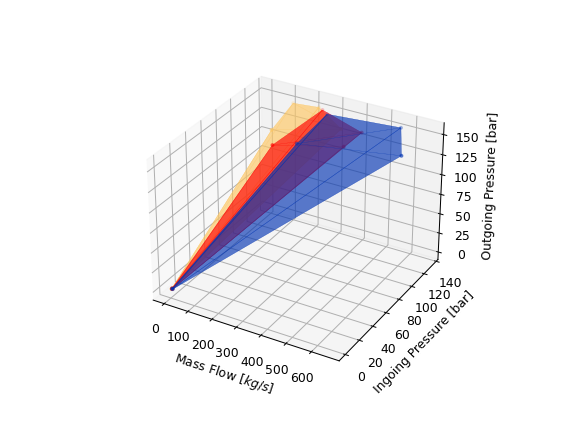

In [6]:
def plot_3d_polytope(polytope, color, ax=None, alpha=0.4):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel(r'Mass Flow $[kg/s]$')
        ax.set_ylabel('Ingoing Pressure [bar]')
        ax.set_zlabel('Outgoing Pressure [bar]')
    assert all(p.is_point() for p in polytope.minimized_generators()), """
    polyhedron has generators that are no points but rays. This implies that the polyhedron is not bounded
    """
    points = np.array([np.array(p.coefficients()).astype(np.float64)/float(p.divisor())
                       for p in polytope.minimized_generators()])
    # Plot points.
    ax.scatter(points[:, 0],
               points[:, 1],
               points[:, 2],
               marker='.',
               color=color)
    c = ConvexHull(points,
                   qhull_options="QJ"
                  )
    # Plot convex hull simplices.
    hull3d = [points[spx] for spx in c.simplices]
    
    hullColl = Poly3DCollection(hull3d, linewidths=0.2,
                                facecolors=color,
                                edgecolors=color, alpha=alpha)
    ax.add_collection3d(hullColl)
    return ax

ax = None
for i, compressor in enumerate(compressors):
    plot_color = compressor['operating range']['plot color']
    ax = plot_3d_polytope(compressor['operating range']['polytope'], plot_color, ax)

plt.show()

# Task 1: Add additional constraints
Now we add the constraint describing the maximum pressure difference to the polytopes. We use the ppl method __[add_constraint](https://pythonhosted.org/pplpy/#ppl.MIP_Problem.add_constraint)__.

In [5]:
############################
###### YOUR CODE HERE ######
############################

# Compressor Station Configurations
A compressor station consists of multiple compressors. These compressors are connected and can be used together in different configurations. A configuration consists of one or more stages. In each stage multiple compressors can compress in parallel. Parallel compression allow more gas to be compressed.

Multiple stages allow consecutive compression. This allows to compress gas more. 

In our example we have 5 configurations. The first three correspond to compression with single machines. Configuration 3 uses two compressors in parallel in a single stage. Configuration 4 is the same as configuration 3, but with a second stage, where the gas is compressed again by compressor 2. 

![Configurations Flow Diagram](configurations.png)

In [6]:
# Our compressor station can be operated in five different configurations

# The first three configurations correspond to the compressors run independently.  
configuration_0 = {
    'stages': {1: {'active compressors': [compressor_1],
                  'polytope': compressor_1['operating range']['polytope']}},
    'polytope': compressor_1['operating range']['polytope']
}
configuration_1 = {
    'stages': {1: {'active compressors': [compressor_2], 
                  'polytope': compressor_2['operating range']['polytope']}},
    'polytope': compressor_2['operating range']['polytope']
}
configuration_2 = {
    'stages': {1: {'active compressors': [compressor_3], 
                  'polytope': compressor_3['operating range']['polytope']}},
    'polytope': compressor_3['operating range']['polytope']
}

# In configuration_4 compressor_1 and compressor_2 compress in parallel. 
configuration_3 = {
    'stages': {1: {'active compressors': [compressor_1, compressor_3], 'polytope': None}},
    'polytope': None
}             
# This configuration has two stages, in the first stage compressor_1 and compressor_2 compress in parallel
# In the second stage compressor_3 compresses the already compressed gas
configuration_4 = {
    'stages':{
    1: {'active compressors': [compressor_1, compressor_3], 'polytope': None},
    2: {'active compressors': [compressor_2], 'polytope': None}
    },
    'polytope': None
}

configurations = [configuration_0, configuration_1, configuration_2, configuration_3, configuration_4]

# Combining operating range polytopes of compressors configured in parallel

We combine the operating range from compressors that are connected in parallel to a single operating range. We have the operating range of compressor $i \in \{1, \dots, n\}$ given in dimensions $q^{i}, p_{\text{in}}^{i}, p_{\text{out}}^{i}$ by constraints

1. $a^{i}_{1_j} q^{i} + a^{i}_{2_j} p_{\text{in}}^{i} + a^{i}_{3_j} p_{\text{out}}^{i} + b^{i}_{j} \geq 0 \qquad \text{for } j \in \{1, \dots, k_i\}$

The gas is divided on multiple compressors while having the same ingoing pressure. So $p_{\text{in}}^{1} = \dots = p_{\text{in}}^{n}=: p_{\text{in}}$. Furthermore the outgoing  pressure is the same, i.e. $p_{\text{out}}^{1} = \dots = p_{\text{out}}^{n}=: p_{\text{out}}$. We are interested in the total flow of the parallel configured compressors which is given by

2. $q = \sum\limits_{i=1}^{n} q^{i}$.

The operating range polytope in the dimensions $q,q^{1}, \dots, q^{n}, p_{\text{in}}, p_{\text{out}}$ can be constructed using the constraints defining the different compressor polytopes (see 1.) combined with the total flow constraint (see 2.). Since we are only interested in the total flow, we project the polytope to the dimensions $q, p_{\text{in}}, p_{\text{out}}$ by removing the other dimensions.

In [7]:
def construct_stage_polytope(stage):
    q  = ppl.Variable(0)
    p_in = ppl.Variable(1)
    p_out = ppl.Variable(2)
    q_ = [ppl.Variable(i+3) for i in range(len(stage['active compressors']))]  # flow variables for each compressor
    
    constraint_system = ppl.Constraint_System()
    
    for i,  compressor in enumerate(stage['active compressors']):
        for count, constraint in enumerate(compressor['operating range']['polytope'].minimized_constraints()):
            # Get coefficients. PPL constraints are of the form a1 x + a2 y + a3 z + b >= 0
            a1, a2, a3 = constraint.coefficients()
            b = constraint.inhomogeneous_term()
            # Insert same constraint in combined constraint system
            constraint_system.insert(a1* q_[i] + a2*p_in + a3*p_out  + b >= 0)
    constraint_system.insert(sum(q_) == q)
    polytope = ppl.C_Polyhedron(constraint_system)
    # Remove all dimensions other than (q,p_in,p_out). This works, since q, pL and pR have been added first.
    polytope.remove_higher_space_dimensions(3)
    stage['polytope'] = polytope
    return polytope
    
# Constructing the configuration_4 polytope
polytope = construct_stage_polytope(configuration_3['stages'][1])
# configuration_4 has only one stage, therefore the configuration polytope is equal to the stage 1 polytope
configuration_3['polytope'] = polytope

<IPython.core.display.Javascript object>


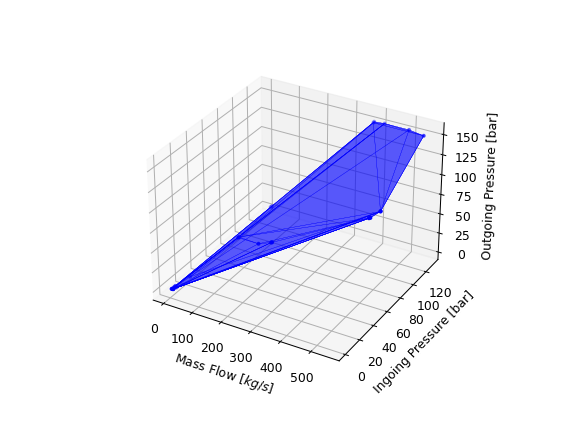

<Axes3DSubplot:xlabel='Mass Flow $[kg/s]$', ylabel='Ingoing Pressure [bar]'>

In [8]:
# Plotting the polytope
# We notice, that by combining the compressors in parallel, more flow can be handled.
plot_3d_polytope(configuration_3['stages'][1]['polytope'], 'blue')

# Task 2: Combining polytopes of different stages
If compression happens in multiple stages, the incoming gas is compressed in each stage.

We combine the polytopes from different stages which are connected in series to a single polytope. We have the polytope of stage $i \in \{1, \dots, n\}$ given in dimensions $q^{i}, p_{\text{in}}^{i}, p_{\text{out}}^{i}$ by constraints

$a^{i}_{1_j} q^{i} + a^{i}_{2_j} p_{\text{in}}^{i} + a^{i}_{3_j} p_{\text{out}}^{i} + b^{i}_{j} \geq 0 \qquad \text{for } j \in \{1, \dots, k_i\}$

For the operating range of a configuration in which first the gas is compressed in multiple stages, it holds true that the ingoing pressure at stage $i$ is equal to the outgoing pressure at stage $i-1$ for $i \in \{2, \dots, n\}$.

Since we are using the norm flow which is not changed by compression of the gas it also holds true that 

$q^{1} = q^{2} = \dots = q^{n}=:q$

We therefore drop the index and use $q$ for all stages. We then create the combined operating range in the dimensions $q, p_{\text{in}}^{i}, p_{\text{out}}^{i}$ with $i \in \{1, \dots, n\}$. 

Since we are interested in how much a configuration can compress gas for a given flow, we are only interested in the dimensions $q, p_{\text{in}}^{1},p_{\text{out}}^{n}$. We can therefore project the polytope to those dimensions by removing the other dimensions. 

In [9]:
def construct_configuration_polytope(configuration):
    number_stages = len(configuration['stages'])
    if number_stages == 1:
        stage_polytope = construct_stage_polytope(configuration['stages'][1])
        configuration['polytope'] = stage_polytope
        return stage_polytope
    else:
        q, p_in, p_out = (ppl.Variable(i) for i in [0, 1, 2])
        # For each stage i except the last we have an extra p_out_i variable.
        # This suffices since the p_in of every stage except the first equals p_out of the previous stage
        p_out_intermediate = list(ppl.Variable(i) for i in range(3, number_stages+3))
        constraint_system = ppl.Constraint_System()
        for i, stage in enumerate(sorted(configuration['stages'])):
            
            stage_polytope = construct_stage_polytope(configuration['stages'][stage])
            
            ############################
            ###### YOUR CODE HERE ######
            ############################
                
        polytope = ppl.C_Polyhedron(constraint_system)
        polytope.remove_higher_space_dimensions(3)
        configuration['polytope'] = polytope
        
        return polytope
polytope = construct_configuration_polytope(configuration_4)

<IPython.core.display.Javascript object>


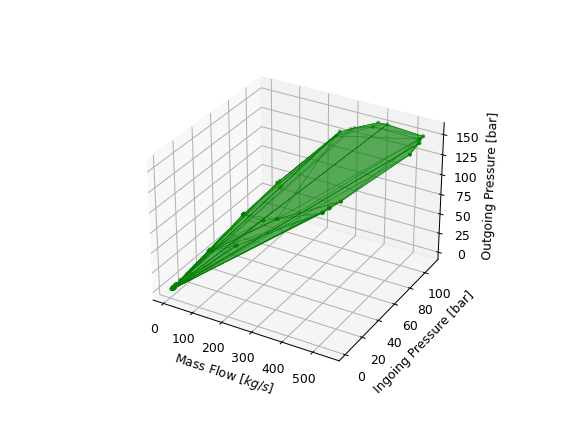

<Axes3DSubplot:xlabel='Mass Flow $[kg/s]$', ylabel='Ingoing Pressure [bar]'>

In [10]:
plot_3d_polytope(polytope, color='green')

# Task 3: Build a PyScipOptModel
We want to model the control decision in which configuration our compressor station should be run. We model this with variable flow $q$ and pressures $p_{\text{in}}, p_{\text{out}}$. This allows us to use the model as a submodel of a bigger model.

We have to model the different capabilities of the configurations, given by the polytopes that we computed. Furthermore, we need to make sure, that only one configuration is chosen.

For configurations $c_i, i \in \{ 1, \dots, n\}$ where the polytope for configuration $i \in \{1, \dots, n \}$ is defined by the constraints $a^{i}_{1_j} q + a^{i}_{2_j} p_{\text{in}} + a^{i}_{3_j} p_{\text{out}} + b^{i}_{j} \geq 0 \qquad \text{for } j \in \{1, \dots, k_i\}$  the constraints of the model can be written using the __[convex-hull reformulation for disjunctive inequalities](https://optimization.mccormick.northwestern.edu/index.php/Disjunctive_inequalities#Convex-Hull_Reformulation)__. To this end we introduce variables $(q^i, p^{i}_{\text{in}}, p^{i}_{\text{out}}) \in \mathbb{R}$ and binary variables $m_{i} \in \{0,1\} \text{ for } i \in \{1,\dots, n\}$. The former are auxillary variables while the latter indicate if configuration $i$ is used.

The constraints of this model are given by

1. $\sum\limits_{i=1}^{n} m_{i} = 1$
2. $a^{i}_{1_j} q^{i} + a^{i}_{2_j} p^{i}_{\text{in}} + a^{i}_{3_j} p^{i}_{\text{out}} + b^{i}_{j}m_{i} \geq 0 \qquad \text{for } i \in \{1, \dots, n\}, j \in \{1, \dots, k_i\}$
3. 
 1. $\sum\limits_{i=1}^{n}q^i = q$
 2. $\sum\limits_{i=1}^{n}p^{i}_{\text{in}} = p_{\text{in}}$
 3. $\sum\limits_{i=1}^{n}p^{i}_{\text{out}} = p_{\text{out}}$
4. $0 \leq q^{i} \leq m_i q_{\text{max}},\qquad 0 \leq p^{i}_{\text{in}} \leq m_i p_{\text{max}}, \qquad0 \leq p^{i}_{\text{out}} \leq m_i p_{\text{max}} \qquad \text{for } i \in \{1, \dots, n\}$

You can add variables to the model using __[model.addVar](https://imada.sdu.dk/~marco/Misc/PySCIPOpt/classpyscipopt_1_1scip_1_1Model.html#ab57ae5cab6f8efb2d48fb13212d637cb)__ and constraints using __[model.addCons](https://imada.sdu.dk/~marco/Misc/PySCIPOpt/classpyscipopt_1_1scip_1_1Model.html#aaeb2227123715120e5921b6633750644)__.

In [11]:
model = Model()

# Define variables
configuration_binaries = [model.addVar(f'm_{i}', vtype="B") for i in range(len(configurations))]
############################
###### YOUR CODE HERE ######
############################

# Task 4: Use the model
Use the model to determine a configuration for the below pressure and flow values. Use an objective that incentivizes the model to pick configuration 3 if possible. Use the method __[fixVar](https://imada.sdu.dk/~marco/Misc/PySCIPOpt/classpyscipopt_1_1scip_1_1Model.html#a7e1a6d19c25ce6643c09274b1143d328)__

In [12]:
q_fix = 120.
p_in_fix = 28.
p_out_fix = 44.

In [ ]:
############################
###### YOUR CODE HERE ######
############################

model.setObjective(objective, sense="maximize")
model.optimize()
print('Model status', model.getStatus())
print('Objective value', model.getObjVal())
print('configuration 3 chosen:', model.getVal(configuration_binaries[3]) == 1)

# Task 5: Why does the model run so long? -> Scale the coefficients

The model takes very long to solve / does not solve. While being very small, this model is numerically hard for the solver since the coefficients of the constraints get as big as $10^{22}$.
In order to make the problem numerically more stable, we scale the constraints. The below method scales the coefficients s.t. they are either $0$ or between $1$ and a fixed maxRatio.

In [ ]:
def scaleCoefficients(coefficients, maxRatio=1e7):
    """
    Method to improve the numerics:
    (1) Change all coefficient to 0.0, for which hold abs(coeff) < maxCoeff / maxRatio,
        where maxRatio is a fixed constant and maxCoeff is the maximum absolute coefficient value
    (2) Afterwards, scale all coeffients to be bigger than 1

    Args
        coeffs : A list of coefficents for some constraint

    Result: A list of all the new coefficients, which are now between 1.0 and maxRatio or exactly at 0.0
    """

    # (1) scale coefficient, s.t. abs(biggest)/abs(smallest) <= maxRatio
    maxCoeff = max(abs(x) for x in coefficients)
    minCoeff = min(abs(x) for x in coefficients if x != 0)
    
    def roundToZero(coefficient, minSize):
        if abs(coefficient) < minSize :
            return 0.0
        else:
            return coefficient
        
    if maxCoeff/minCoeff > maxRatio:
        # all coefficients to small to be in the threshold will become zero
        minSize = maxCoeff / maxRatio
        coefficients = [roundToZero(x, minSize) for x in coefficients]

    # (2) now scale everything, s.t. for all coeffs holds: abs(coeff) >= 1.0 iff coeff != 0.0
    def determineScaling(scaling, coeff):
        if coeff != 0.0:
            neededScalingExponent = - int(np.floor(np.log10(abs(coeff))))
            #print("neededScalingExponent: "+str(neededScalingExponent))
            if scaling is None:
                return neededScalingExponent
            else:
                return max(neededScalingExponent, scaling)
        else:
            return scaling

    scaling = None
    for x in coefficients:
        scaling = determineScaling( scaling, x )

    if (not (scaling is None)) and scaling != 0:
        factor = np.power(10., scaling)
        coefficients = [x * factor for x in coefficients]


    return coefficients

# Homework
Your homework is to add a time dimension to the model. That means, we have variables $(q)_t, (p_{\text{in}})_t,  (p_{\text{out}})_t$ as well as $(q^i)_t, (p^{i}_{\text{in}})_t, (p^{i}_{\text{out}})_t) \in \mathbb{R}$ and binary variables $(m_{i})_t \in \{0,1\} \text{ for } i \in \{1,\dots, n\}$  for each timestep $t \in \{1, \dots, s\}$.

The objective should be, that the number of configuration changes is minimized. This is the only coupling of different timesteps.

The number of timesteps is 12.

(Hint: You might need to introduce extra variables to keep track of configuration changes)

In [ ]:
############################
###### YOUR CODE HERE ######
############################

# Test your model with the following flow pressure profile
Each row corresponds to $[q, p_{\text{in}},p_{\text{out}}]$ for one timestep

In [ ]:
flow_pressure_profile = [                        # feasible configurations for profile
    [101.09849209,  64.82602704,  86.97953347],  # 0
    [131.24724021,  50.06975252,  68.83571091],  # 0, 1, 2
    [151.39654506,  42.34376185,  51.82579014],  # 1, 3
    [178.02064897,  61.52977243,  78.89406364],  # 1, 2
    [267.45636842,  77.84430455,  94.77232514],  # 1, 3
    [260.69592621,  53.4128448 ,  68.33852875],  # 1, 3
    [388.81182121,  74.01446441,  99.95237716],  # 3
    [424.93896237,  76.83609014,  97.58111236],  # 3
    [362.9312044 ,  66.31572729, 103.25359683],  # 4
    [260.69592621,  53.4128448 ,  68.33852875],  # 1, 3
    [220.98964295,  47.89412227,  71.02034818],  # 1, 3, 4
    [123.56115777,  23.6524077 ,  34.9214887 ],  # 1, 3, 4 
]

In [ ]:
for t, (q_fix, p_in_fix, p_out_fix) in enumerate(flow_pressure_profile):
    model.fixVar(q[t], q_fix)
    model.fixVar(p_in[t], p_in_fix)
    model.fixVar(p_out[t], p_out_fix)
model.optimize()
print('Model status (should be optimal)', model.getStatus())
print('Objective value (should be 4)', model.getObjVal())
for t, configuration_binaries in enumerate(all_configuration_binaries):
    for cfg_id, cfg in enumerate(configuration_binaries):
        if model.getVal(cfg) == 1:
            print(f'Configuration chosen at timestep {t}: {cfg_id}')